In [15]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Tarefa - Robustez e Falhas em Cascata
## PCC121 - Redes Complexas
Aluno: Gabriel F. Costa

Simulando falhas aleatórias: 100%|██████████| 30/30 [00:09<00:00,  3.08it/s]


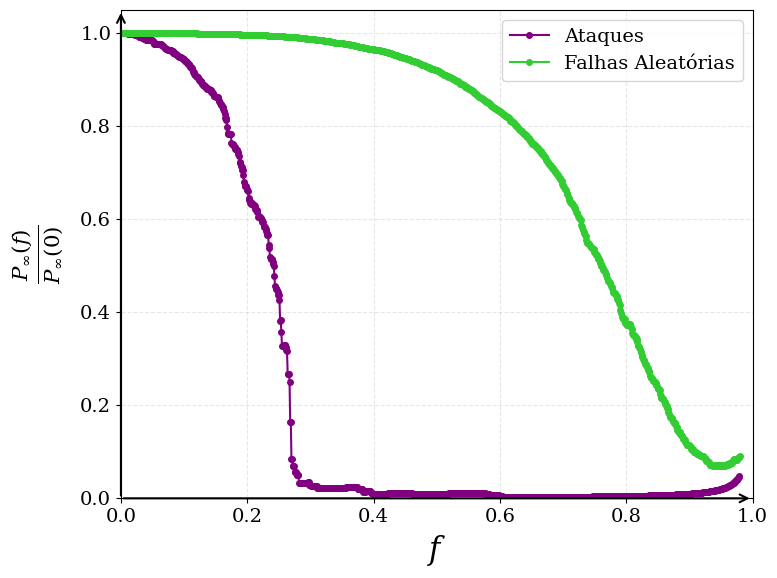

In [16]:
# -*- coding: utf-8 -*-
"""
Simulação de robustez e falhas em cascata em redes Barabási–Albert (N=1000, m=3)
Reprodução da Figura 8.11 do livro *Network Science* (Barabási, 2016).

- Curva roxa: ataques direcionados (remoção de nós de maior grau)
- Curva verde: falhas aleatórias (remoção de nós ao acaso)
"""

# ==============================================================
# ETAPA 1 — Função para calcular o maior componente conectado
# ==============================================================

def largest_component_fraction(G):
    """
    Retorna a fração de nós pertencentes ao maior componente conectado.
    Essa métrica mede o quanto a rede ainda está "inteira" após remoções.
    """
    if len(G) == 0:
        return 0
    largest_cc = max(nx.connected_components(G), key=len)
    return len(largest_cc) / len(G.nodes)


# ==============================================================
# ETAPA 2 — Simulação de ataques direcionados
# ==============================================================

def robustness_attack(G):
    """
    Remove nós em ordem decrescente de grau (ataques direcionados).
    Calcula a fração do maior componente após cada remoção.
    """
    # Cópia da rede original (para não alterar o grafo base)
    G_copy = G.copy()

    # Ordena nós pelo grau (maior → menor)
    degrees = sorted(G_copy.degree, key=lambda x: x[1], reverse=True)
    nodes_sorted = [n for n, _ in degrees]

    f_values, S_values = [], []  # listas para armazenar fração removida e conectividade
    N = len(G_copy)
    initial_size = largest_component_fraction(G_copy)  # tamanho inicial normalizador

    # Loop principal: remove um nó por vez e mede conectividade
    for i, node in enumerate(tqdm(nodes_sorted, desc="Simulando ataques")):
        G_copy.remove_node(node)
        f = (i + 1) / N  # fração de nós removidos
        S = largest_component_fraction(G_copy) / initial_size
        S_values.append(S)
        f_values.append(f)

    # Clipa valores em [0, 1] para evitar picos numéricos
    S_values = np.clip(S_values, 0, 1)
    return np.array(f_values), np.array(S_values)


# ==============================================================
# ETAPA 3 — Simulação de falhas aleatórias
# ==============================================================

def robustness_failure(G, simulations=50):
    """
    Remove nós em ordem aleatória (falhas não direcionadas).
    Realiza várias simulações independentes e retorna a média das curvas.
    """
    N = len(G)
    initial_size = largest_component_fraction(G)
    f_values = np.linspace(0, 1, N)
    S_matrix = []

    # Repetição de várias execuções independentes
    for _ in tqdm(range(simulations), desc="Simulando falhas aleatórias"):
        G_copy = G.copy()
        nodes = list(G_copy.nodes)
        random.shuffle(nodes)  # ordem aleatória dos nós
        S_values = []

        for i, node in enumerate(nodes):
            G_copy.remove_node(node)
            f = (i + 1) / N
            S = largest_component_fraction(G_copy) / initial_size
            S_values.append(S)

        # Corrige eventuais flutuações >1 ou <0
        S_matrix.append(np.clip(S_values, 0, 1))

    # Média de todas as simulações
    return f_values, np.mean(S_matrix, axis=0)


# ==============================================================
# ETAPA 4 — Geração da rede Barabási–Albert
# ==============================================================

# Gera uma rede com 1000 nós, onde cada novo nó se conecta a 3 já existentes
# (modelo de crescimento preferencial, resultando em distribuição de grau ~k^-3)
G = nx.barabasi_albert_graph(1000, 3, seed=42)


# ==============================================================
# ETAPA 5 — Execução das simulações
# ==============================================================

# Executa ataque direcionado (por grau) e falhas aleatórias
f_attack, S_attack = robustness_attack(G)
f_failure, S_failure = robustness_failure(G, simulations=30)

# Remove valores ruidosos no final (f → 1)
mask_attack = f_attack < 0.98
mask_failure = f_failure < 0.98


# ==============================================================
# ETAPA 6 — Configuração de estilo do gráfico
# ==============================================================

plt.rcParams.update({
    "text.usetex": False,                  # Usa mathtext nativo do Matplotlib
    "font.family": "serif",
    "mathtext.fontset": "dejavuserif",
    "font.size": 14,
    "axes.labelsize": 18,
    "legend.fontsize": 14
})

plt.figure(figsize=(8, 6))


# ==============================================================
# ETAPA 7 — Plot das curvas principais
# ==============================================================

plt.plot(f_attack[mask_attack], S_attack[mask_attack],
         'o-', color='purple', markersize=4, label="Ataques")
plt.plot(f_failure[mask_failure], S_failure[mask_failure],
         'o-', color='limegreen', markersize=4, label="Falhas Aleatórias")


# ==============================================================
# ETAPA 8 — Rótulos, legendas e estética final
# ==============================================================

# Rótulos matemáticos dos eixos
plt.xlabel(r"$f$", fontsize=22, labelpad=5)
plt.ylabel(r"$\frac{P_\infty(f)}{P_\infty(0)}$", fontsize=22, labelpad=10)

# Define limites dos eixos e ativa grade leve
plt.xlim(0, 1)          # (corrigido: o terceiro parâmetro .25 era inválido)
plt.ylim(0, 1.05)
plt.grid(alpha=0.3, linestyle="--")

# Legenda com fundo branco (posição automática)
plt.legend(frameon=True, facecolor='white', loc="best")


# ==============================================================
# ETAPA 9 — Desenho das setas nos eixos (estilo do livro)
# ==============================================================

ax = plt.gca()
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

# Define propriedades das setas (finas e elegantes)
arrowprops = dict(arrowstyle="->", color="black", linewidth=1.5)
ax.annotate("", xy=(xmax, 0), xytext=(xmin, 0), arrowprops=arrowprops)  # eixo x
ax.annotate("", xy=(0, ymax), xytext=(0, ymin), arrowprops=arrowprops)  # eixo y

# Ajusta o layout para não cortar rótulos
plt.tight_layout()

# Exibe o gráfico final
plt.show()